## Importing relevant packages

In [1]:
import yfinance as yf # fetching data
import pandas as pd # DataFrame operations
import numpy as np
import seaborn as sns
import statsmodels as sts
import matplotlib.pyplot as plt # plotting
import scipy.stats
import pylab
import statsmodels.tsa.stattools as sts # for the .adfuller()
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA # Modelling

import warnings
warnings.filterwarnings("ignore")

## LLR Test

In [2]:
def LLR_test(mod_1, mod_2, DF=1):
    L1 = mod_1.fit().llf 
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [3]:
ticker = 'AAPL'
apple = yf.Ticker(ticker).history(interval = '1d', start = '2019-01-01', end = '2024-01-01', auto_adjust = True)

In [4]:
apple.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.000000
mean,121.290145,122.685257,120.002950,121.413824,1.015904e+08,0.003412,0.003180
std,46.742083,47.167777,46.321408,46.758670,5.261087e+07,0.026950,0.112777
min,34.504364,34.921351,34.029864,34.075397,2.404830e+07,0.000000,0.000000
25%,74.882997,75.920997,74.219578,75.294870,6.803012e+07,0.000000,0.000000
50%,132.840378,133.933938,131.114129,132.488846,8.861740e+07,0.000000,0.000000
75%,158.351993,160.645656,155.846313,158.011349,1.189786e+08,0.000000,0.000000
max,197.767647,199.365599,196.748941,197.857529,4.265100e+08,0.240000,4.000000


In [5]:
apple.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 00:00:00-05:00 to 2023-12-29 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1258 non-null   float64
 1   High          1258 non-null   float64
 2   Low           1258 non-null   float64
 3   Close         1258 non-null   float64
 4   Volume        1258 non-null   int64  
 5   Dividends     1258 non-null   float64
 6   Stock Splits  1258 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.6 KB


In [6]:
apple.isna().sum()

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
dtype: int64

Text(0.5, 1.0, 'Apple Closing Price')

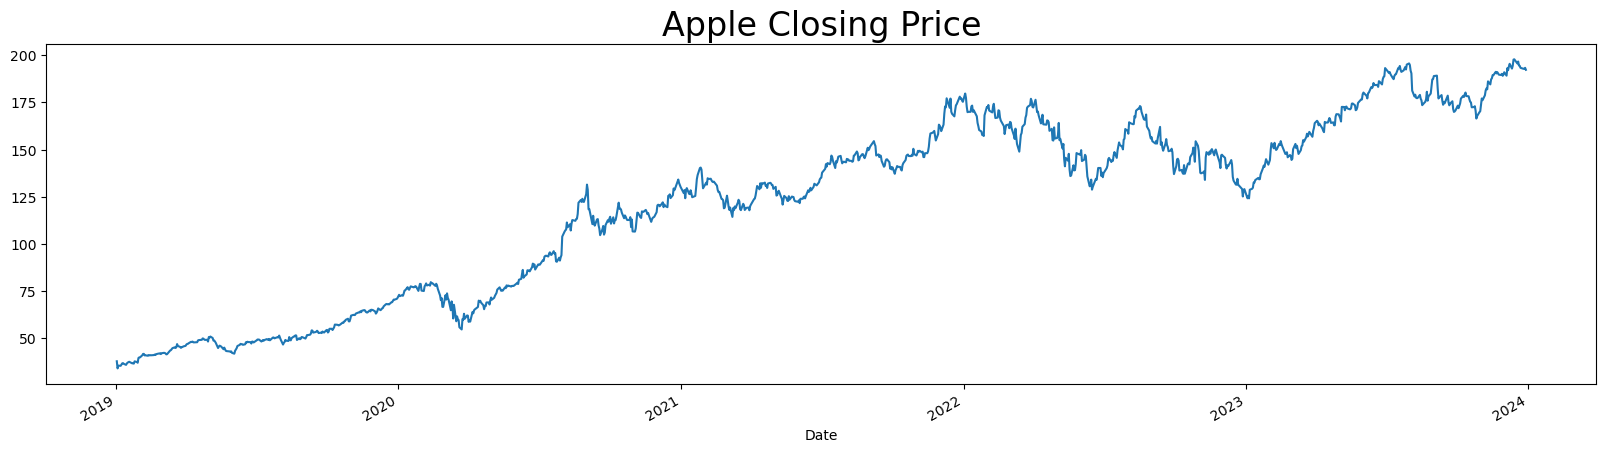

In [7]:
apple.Close.plot(figsize = (20,5))
plt.title("Apple Closing Price", size = 24)

In [8]:
apple = apple.reset_index()
apple.Date = pd.to_datetime(apple.Date).dt.date
apple.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2019-01-02,37.118910,38.067913,36.960742,37.845039,148158800,0.0,0.0
1,2019-01-03,34.504364,34.921351,34.029864,34.075397,365248800,0.0,0.0
2,2019-01-04,34.636170,35.599552,34.461229,35.530052,234428400,0.0,0.0
3,2019-01-07,35.635507,35.666662,34.964494,35.450977,219111200,0.0,0.0
4,2019-01-08,35.841593,36.383198,35.592362,36.126774,164101200,0.0,0.0


In [9]:
apple.Date.describe()

count           1258
unique          1258
top       2019-01-02
freq               1
Name: Date, dtype: object

In [10]:
apple.set_index('Date', inplace = True)
apple.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,37.118910,38.067913,36.960742,37.845039,148158800,0.0,0.0
2019-01-03,34.504364,34.921351,34.029864,34.075397,365248800,0.0,0.0
2019-01-04,34.636170,35.599552,34.461229,35.530052,234428400,0.0,0.0
2019-01-07,35.635507,35.666662,34.964494,35.450977,219111200,0.0,0.0
2019-01-08,35.841593,36.383198,35.592362,36.126774,164101200,0.0,0.0


In [11]:
del apple['Dividends']
del apple['Stock Splits']

## Setting the desired frequency

In [12]:
apple = apple.asfreq('b') #Setting the frequency to Business days so we avoid NaNs in out dataset
apple.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,37.118910,38.067913,36.960742,37.845039,148158800.0
2019-01-03,34.504364,34.921351,34.029864,34.075397,365248800.0
2019-01-04,34.636170,35.599552,34.461229,35.530052,234428400.0
2019-01-07,35.635507,35.666662,34.964494,35.450977,219111200.0
2019-01-08,35.841593,36.383198,35.592362,36.126774,164101200.0


In [13]:
apple.isna().sum()

Open      45
High      45
Low       45
Close     45
Volume    45
dtype: int64

## Handling Missing Values

In [14]:
apple = apple.fillna(method = 'ffill')

In [17]:
apple.isna().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

## Splitting the Data
Discuss the splitting proportion process

In [15]:
size = int(len(apple) * 0.8)

In [16]:
df, df_test = pd.DataFrame(apple.Close.iloc[:size]), pd.DataFrame(apple.Close.iloc[size:])

In [17]:
df.tail()

,Close
Date,
2022-12-23,130.959946
2022-12-26,130.959946
2022-12-27,129.142456
2022-12-28,125.179688
2022-12-29,128.725327


In [18]:
df_test.head()

,Close
Date,
2022-12-30,129.043137
2023-01-02,129.043137
2023-01-03,124.216293
2023-01-04,125.497498
2023-01-05,124.166641


## Check whether the Time-Series is White Noise
https://machinelearningmastery.com/white-noise-time-series-python/#:~:text=White%20noise%20is%20an%20important%20concept%20in%20time%20series%20analysis,model%20it%20and%20make%20predictions.

## Generating the white noise

In [19]:
wn = np.random.normal(
    loc = df.mean(), 
    scale = df.std(), 
    size = len(df)
)

In [20]:
df['wn'] = wn
print(df.describe()) #the mean is similar but the distribution is different
df.head()

             Close           wn
count  1042.000000  1042.000000
mean    108.894878   105.453510
std      43.167139    41.962051
min      34.075397   -11.427350
25%      65.043806    76.951217
50%     121.538078   106.175494
75%     145.562946   132.659366
max     179.724548   254.520048


,Close,wn
Date,,
2019-01-02,37.845039,84.826820
2019-01-03,34.075397,71.916965
2019-01-04,35.530052,89.169718
2019-01-07,35.450977,86.808358
2019-01-08,36.126774,152.986678


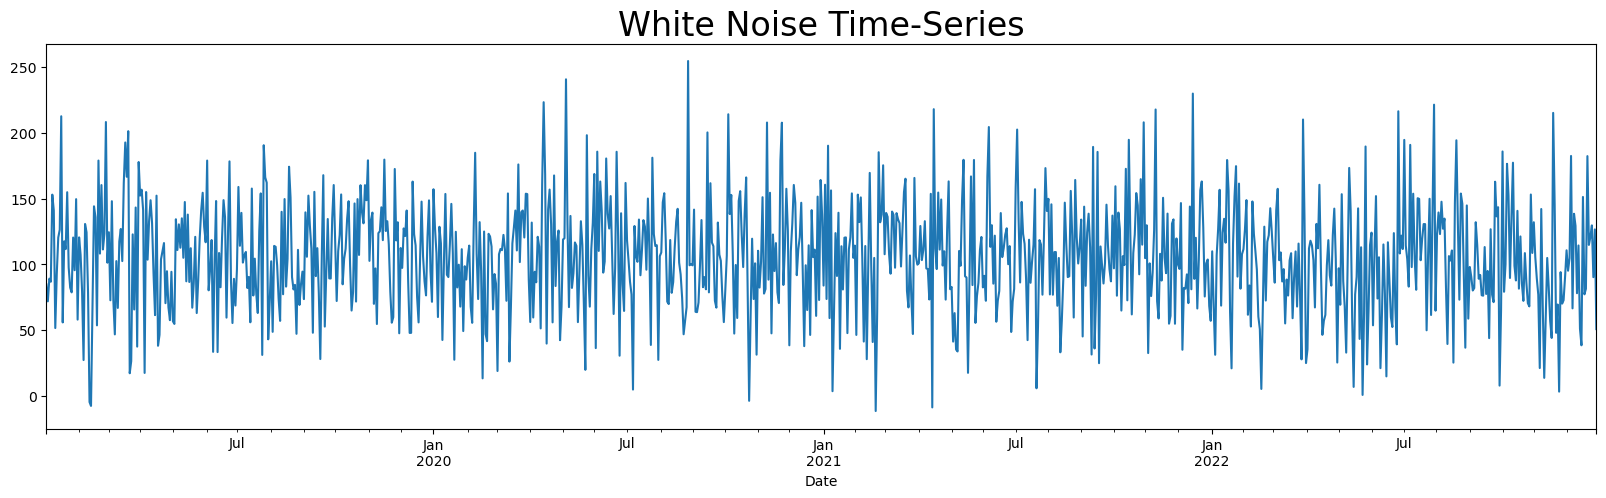

In [21]:
df.wn.plot(figsize = (20,5))
plt.title('White Noise Time-Series', size = 24)
plt.show()

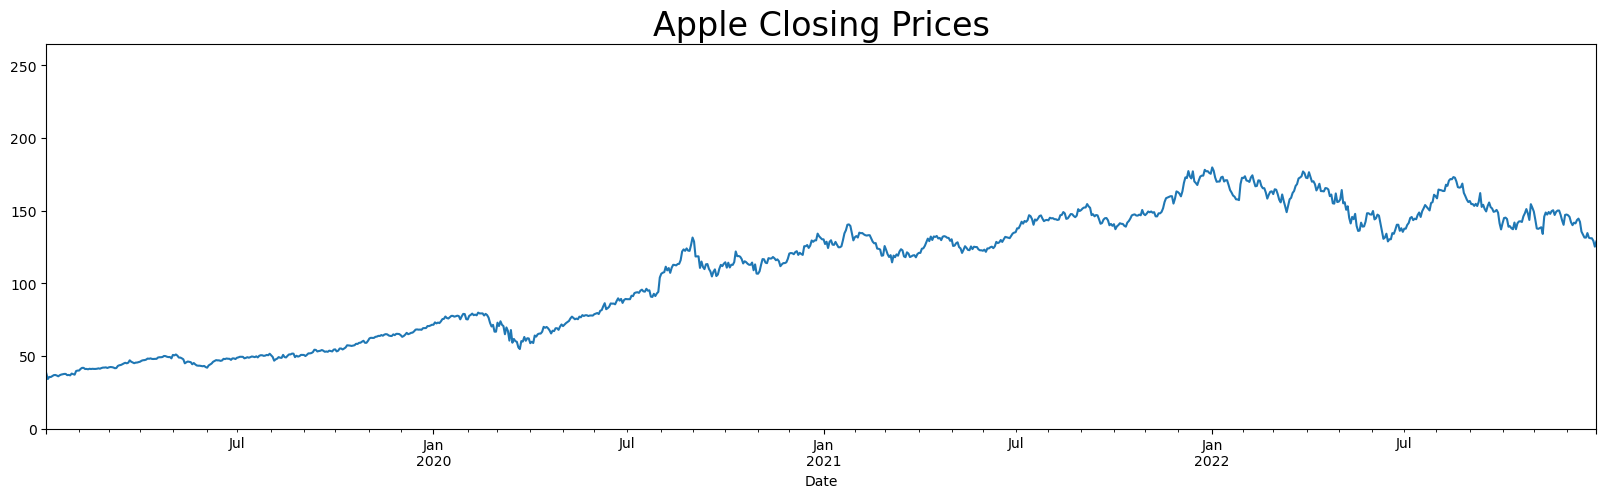

In [28]:
df.Close.plot(figsize = (20,5))
plt.title('Apple Closing Prices', size = 24)
plt.ylim(0, 265) #so we have the same magnitude for the 2 charts, more comparable
plt.show()

In [29]:
sts.adfuller(df.Close)

(-1.6252029549667921,
 0.47000265957457105,
 10,
 1031,
 {'1%': -3.4367085412302205,
  '5%': -2.8643474145110512,
  '10%': -2.568264786168072},
 4665.609538344304)

Text(0.5, 1.0, 'PACF for Closing prices')

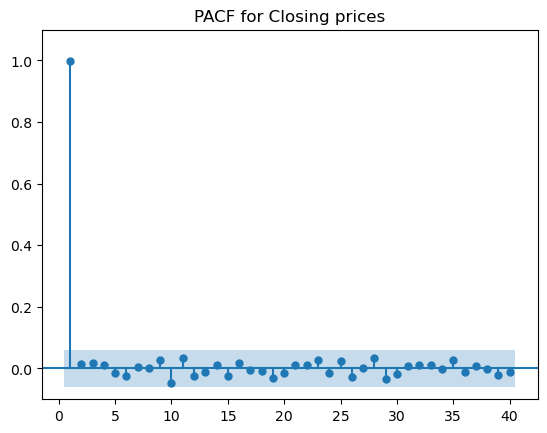

In [30]:
sgt.plot_pacf(df.Close, zero = False, lags = 40)
plt.ylim(-0.1,1.1)
plt.title('PACF for Closing prices')

In [31]:
model_ar_1 = ARIMA(df.Close, order = (1,0,0))
results_ar_1 = model_ar_1.fit()
results_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1042
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2382.780
Date:                Wed, 28 Feb 2024   AIC                           4771.560
Time:                        09:48:21   BIC                           4786.407
Sample:                    01-02-2019   HQIC                          4777.192
                         - 12-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        106.6396     29.642      3.598      0.000      48.543     164.737
ar.L1          0.9987      0.001    673.035      0.000       0.996       1.002
sigma2         5.6398      0.157     35.833      0.000       5.331       5.948
===================================================================================
Ljung-Box (L1) (Q):                   4.32   Jarque-Bera (JB):               374.81
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               4.70   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [32]:
model_ar_2 = ARIMA(df.Close, order = (2,0,0))
results_ar_2 = model_ar_2.fit()
results_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                 1042
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2380.649
Date:                Wed, 28 Feb 2024   AIC                           4769.298
Time:                        09:48:54   BIC                           4789.093
Sample:                    01-02-2019   HQIC                          4776.806
                         - 12-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.3444     31.603      3.428      0.001      46.403     170.285
ar.L1          0.9345      0.023     40.487      0.000       0.889       0.980
ar.L2          0.0643      0.023      2.782      0.005       0.019       0.110
sigma2         5.6167      0.161     34.806      0.000       5.300       5.933
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               342.61
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               4.88   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
LLR_test(model_ar_1, model_ar_2)

0.039

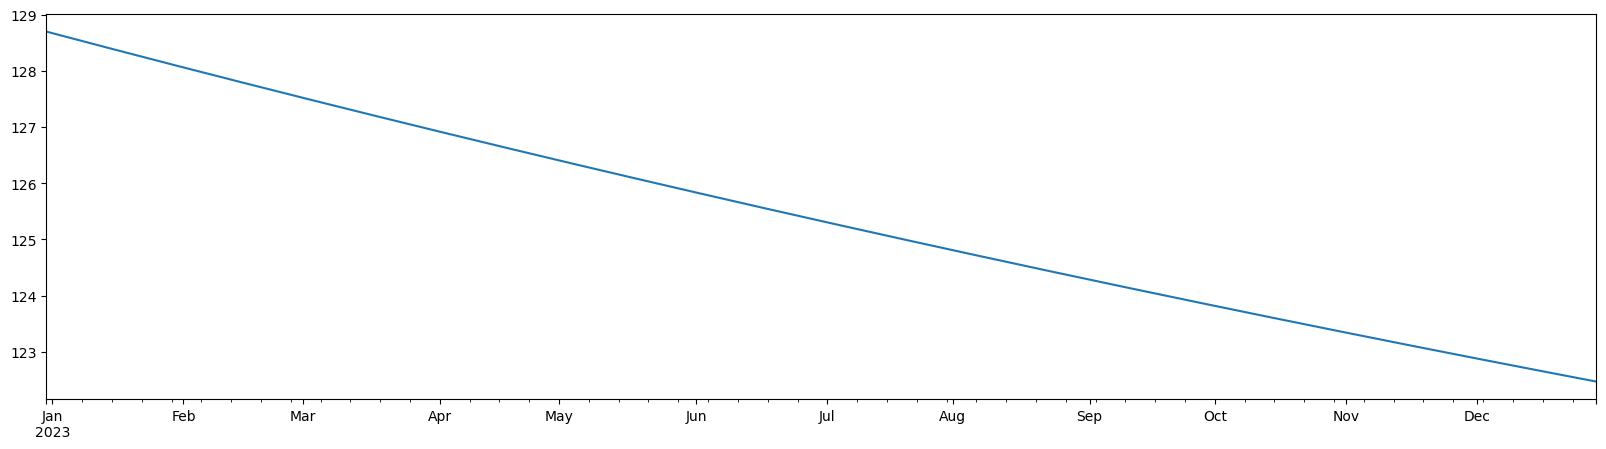

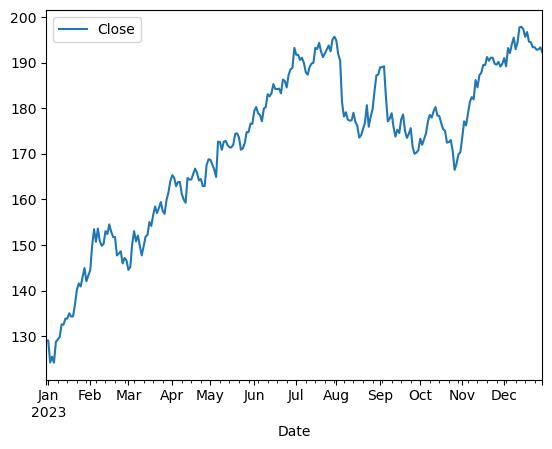

In [34]:
df_pred = results_ar_1.forecast(len(df_test))

df_pred.plot(figsize = (20,5))
df_test.plot()
plt.show()


In [35]:
df['returns'] = df.Close.pct_change(1).mul(100)
df = df.iloc[1:]

In [36]:
sts.adfuller(df.returns)

(-10.08443823893895,
 1.1654218762395376e-17,
 8,
 1032,
 {'1%': -3.4367023644255537,
  '5%': -2.864344690221488,
  '10%': -2.5682633351736674},
 4376.237901975776)

Text(0.5, 1.0, 'ACF for Returns')

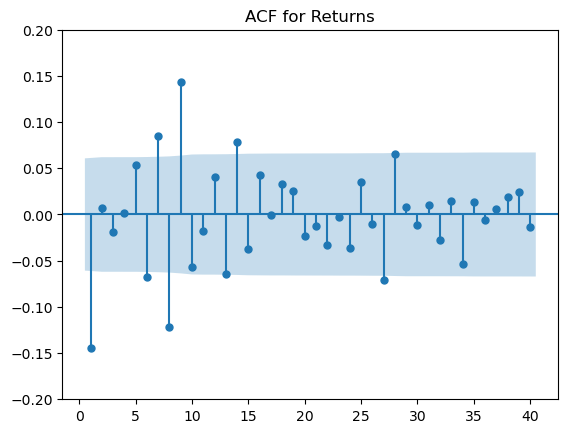

In [39]:
sgt.plot_acf(df.returns, zero = False, lags = 40)
plt.ylim(-0.2, 0.2)
plt.title('ACF for Returns')

Text(0.5, 1.0, 'PACF for Returns')

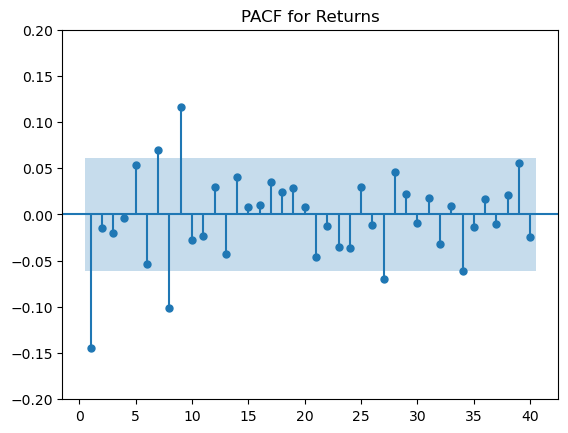

In [41]:
sgt.plot_pacf(df.returns, zero = False, lags = 40)
plt.ylim(-0.2, 0.2)
plt.title('PACF for Returns')

In [42]:
model_ret_ar_1 = ARIMA(df.returns, order = (1,0,0))
results_ret_ar_1 = model_ret_ar_1.fit()
results_ret_ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1041
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2258.383
Date:                Wed, 28 Feb 2024   AIC                           4522.765
Time:                        09:51:30   BIC                           4537.609
Sample:                    01-03-2019   HQIC                          4528.396
                         - 12-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1414      0.058      2.456      0.014       0.029       0.254
ar.L1         -0.1479      0.020     -7.379      0.000      -0.187      -0.109
sigma2         4.4860      0.118     38.098      0.000       4.255       4.717
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               751.98
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.82   Skew:                            -0.09
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
model_ret_ar_2 = ARIMA(df.returns, order = (2,0,0))
results_ret_ar_2 = model_ret_ar_2.fit()
results_ret_ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1041
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -2258.290
Date:                Wed, 28 Feb 2024   AIC                           4524.580
Time:                        09:51:36   BIC                           4544.371
Sample:                    01-03-2019   HQIC                          4532.087
                         - 12-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1416      0.058      2.430      0.015       0.027       0.256
ar.L1         -0.1498      0.021     -7.066      0.000      -0.191      -0.108
ar.L2         -0.0135      0.022     -0.626      0.532      -0.056       0.029
sigma2         4.4853      0.119     37.647      0.000       4.252       4.719
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               747.38
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.10
Prob(H) (two-sided):                  0.06   Kurtosis:                         7.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
LLR_test(model_ret_ar_1, model_ret_ar_2)

0.667

In [45]:
model_ret_ar_3 = ARIMA(df.returns, order = (3,0,0))
results_ret_ar_3 = model_ret_ar_3.fit()
results_ret_ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1041
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2258.078
Date:                Wed, 28 Feb 2024   AIC                           4526.155
Time:                        09:51:57   BIC                           4550.895
Sample:                    01-03-2019   HQIC                          4535.539
                         - 12-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1417      0.058      2.451      0.014       0.028       0.255
ar.L1         -0.1501      0.022     -6.900      0.000      -0.193      -0.107
ar.L2         -0.0164      0.023     -0.726      0.468      -0.061       0.028
ar.L3         -0.0204      0.024     -0.862      0.389      -0.067       0.026
sigma2         4.4834      0.120     37.451      0.000       4.249       4.718
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               769.43
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.11
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
LLR_test(model_ret_ar_1, model_ret_ar_3, DF=2)

0.737

In [48]:
model_ret_ar_4 = ARIMA(df.returns, order = (4,0,0))
results_ret_ar_4 = model_ret_ar_4.fit()
results_ret_ar_4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1041
Model:                 ARIMA(4, 0, 0)   Log Likelihood               -2258.072
Date:                Wed, 28 Feb 2024   AIC                           4528.145
Time:                        09:52:20   BIC                           4557.833
Sample:                    01-03-2019   HQIC                          4539.406
                         - 12-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1417      0.058      2.431      0.015       0.027       0.256
ar.L1         -0.1501      0.023     -6.653      0.000      -0.194      -0.106
ar.L2         -0.0165      0.023     -0.727      0.467      -0.061       0.028
ar.L3         -0.0209      0.025     -0.840      0.401      -0.070       0.028
ar.L4         -0.0031      0.023     -0.134      0.893      -0.049       0.043
sigma2         4.4834      0.120     37.448      0.000       4.249       4.718
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               767.18
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.11
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
LLR_test(model_ret_ar_1, model_ret_ar_4, DF=3)

0.892

In [50]:
model_ret_ar_5 = ARIMA(df.returns, order = (5,0,0))
results_ret_ar_5 = model_ret_ar_5.fit()
results_ret_ar_5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 1041
Model:                 ARIMA(5, 0, 0)   Log Likelihood               -2256.471
Date:                Wed, 28 Feb 2024   AIC                           4526.941
Time:                        09:52:32   BIC                           4561.577
Sample:                    01-03-2019   HQIC                          4540.079
                         - 12-29-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1414      0.062      2.288      0.022       0.020       0.263
ar.L1         -0.1502      0.023     -6.594      0.000      -0.195      -0.106
ar.L2         -0.0154      0.023     -0.678      0.498      -0.060       0.029
ar.L3         -0.0199      0.025     -0.794      0.427      -0.069       0.029
ar.L4          0.0048      0.025      0.196      0.845      -0.044       0.053
ar.L5          0.0561      0.022      2.517      0.012       0.012       0.100
sigma2         4.4696      0.119     37.588      0.000       4.237       4.703
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               771.35
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.81   Skew:                            -0.09
Prob(H) (two-sided):                  0.05   Kurtosis:                         7.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [51]:
LLR_test(model_ret_ar_4, model_ret_ar_5, DF=1)

0.073

In [52]:
start_date = '2019-03-14'
end_date = '2023-12-29'

In [57]:
df_pred = results_ret_ar_5.predict(start = start_date, end = end_date)

In [58]:
df_test['returns'] = df_test.Close.pct_change(1).mul(100)
df_test = df_test[1:]

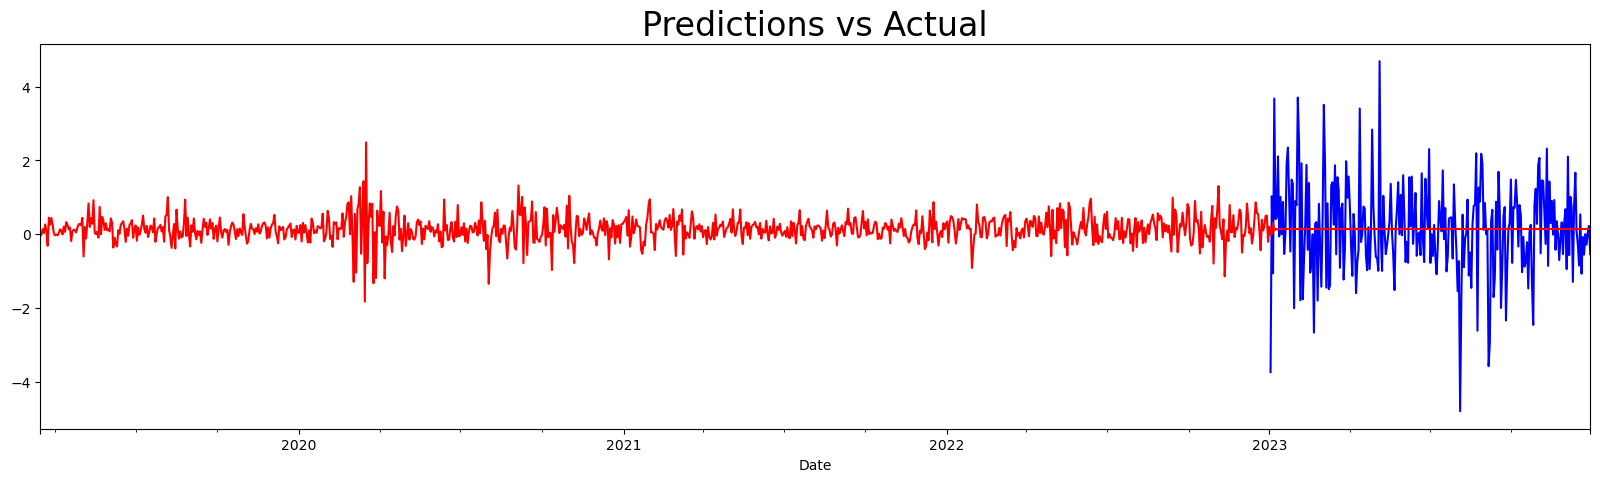

In [59]:
df_test.returns[start_date:end_date].plot(color = "blue")
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
plt.title("Predictions vs Actual", size = 24)
plt.show()

In [60]:
df_test

,Close,returns
Date,,
2023-01-03,124.216293,-3.740488
2023-01-04,125.497498,1.031430
2023-01-05,124.166641,-1.060464
2023-01-06,128.735245,3.679413
2023-01-09,129.261642,0.408899
...,...,...
2023-12-25,193.353287,0.000000
2023-12-26,192.803986,-0.284092
2023-12-27,192.903839,0.051790


In [61]:
last_known_price = df['Close'].iloc[-1]
last_known_price
predicted_prices = pd.Series(index=df_pred.index)
predicted_prices.iloc[0] = last_known_price * (1 + df_pred.iloc[0])
for i in range(1, len(df_pred)):
    predicted_prices.iloc[i] = predicted_prices.iloc[i-1] * (1 + df_pred.iloc[i])

<Axes: xlabel='Date'>

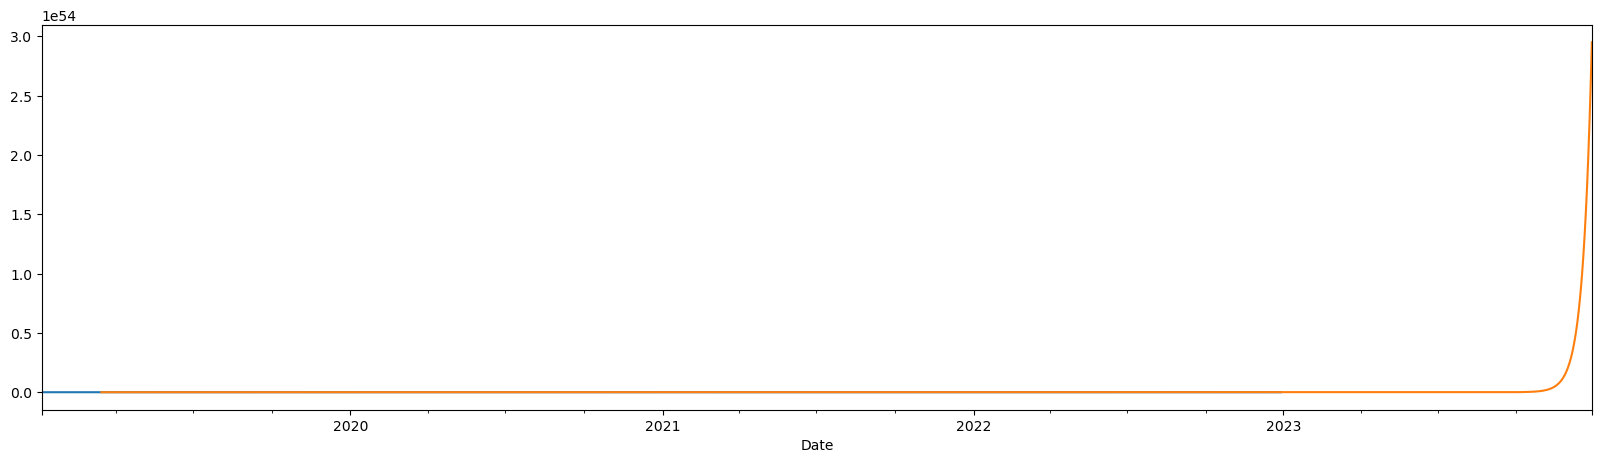

In [62]:
df.Close.plot(figsize=(20,5))
predicted_prices.plot()